In [1]:
import pandas as pd
import numpy as np
from scaling import standardize, normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from collections import Counter

from RandomForest import evaluate_rfc, create_roc_curve

In [2]:
df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv', index_col=None, header=0)
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv', index_col=None, header=0)
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv', index_col=None, header=0)
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv', index_col=None, header=0)
df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv', index_col=None, header=0)
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv', index_col=None, header=0)
df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv', index_col=None, header=0)

all_files = [df2015, df2016, df2017, df2018, df2019, df2020, df2021]

df = pd.concat(all_files, axis=0, ignore_index=True)

untouched_df = pd.concat(all_files, axis=0, ignore_index=True)

In [3]:
df = df.drop(columns=['source_id', 'individual', 'owner_id', 'name',  'distance', 'sin_time', 'cos_time', 'date_time',
                      'longitude', 'latitude', 'temperature', 'altitude'])

df = standardize(df, ['velocity', 'angle']) # standarize the data
df = normalize(df, ['velocity', 'angle'], 0, 1) # normalize the data

X = df.drop(['attack'], axis=1) # Features
y = df['attack'] # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('attack', axis=1), df['attack'], test_size=0.1, random_state=42, stratify=y)

roc_auc_score for RandomForestClassifier:  0.5089419473374305


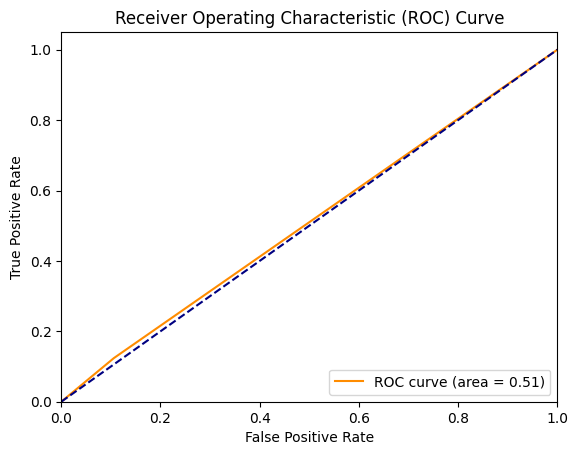

Accuracy: 88.31 %
[[21108  2503]
 [  297    42]]
              precision    recall  f1-score   support

           0      0.986     0.894     0.938     23611
           1      0.017     0.124     0.029       339

    accuracy                          0.883     23950
   macro avg      0.501     0.509     0.483     23950
weighted avg      0.972     0.883     0.925     23950



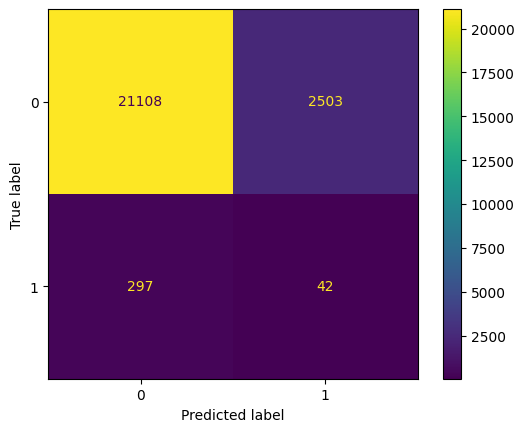

In [8]:
# Use SMOTE to oversample the minority class
oversample = SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

# Build SMOTE SRF model
rf = RandomForestClassifier(n_estimators=300, max_depth=100, class_weight='balanced_subsample', random_state=42, n_jobs=-1)

# Train SMOTE SRF
rf.fit(X_train_resampled, y_train_resampled)

# SMOTE SRF prediction result
y_pred = rf.predict(X_test)

# Performance matrix
create_roc_curve(y_test=y_test, y_pred=y_pred)
evaluate_rfc(rf, y_test=y_test, y_pred=y_pred)

In [45]:
y_pred_count = Counter(y_pred)
y_test_count = y_test.value_counts()

print('y_test (faktisk):\n', y_test_count)
print('y_pred (predikert):', y_pred_count)

y_test (faktisk):
 0    23611
1      339
Name: attack, dtype: int64
y_pred (predikert): Counter({0: 21431, 1: 2519})


# Statistics for TP, FP, TN, FN

In [46]:
# the first condition checks if the predicted label is 1, and the second condition checks if the true label is 0
false_positives_idx = (y_pred == 1) & (y_test == 0)
true_positives_idx = (y_pred == 1) & (y_test == 1)

false_negatives_idx = (y_pred == 0) & (y_test == 1)
true_negatives_idx = (y_pred == 0) & (y_test == 0)

# Filter the rows of X_test that correspond to false positives
false_positives = X_test[false_positives_idx]
true_positives = X_test[true_positives_idx]
false_negatives = X_test[false_negatives_idx]
true_negatives = X_test[true_negatives_idx]

print('False positives:', len(false_positives))
print('True positives:', len(true_positives))
print('False negatives:', len(false_negatives))
print('True negatives:', len(true_negatives))

False positives: 2479
True positives: 40
False negatives: 299
True negatives: 21132


Statistcs standaried and normalized

In [47]:
# subsetting the feature matrix with the masks and calculating the means
tp_mean = np.mean(true_positives)
fp_mean = np.mean(false_positives)
fn_mean = np.mean(false_negatives)
tn_mean = np.mean(true_negatives)


# De som er predikert 1 og er faktisk 1
print('True positive mean:\n', tp_mean)
print('--------------------------------------------------')
print('False positive mean:\n', fp_mean)
print('--------------------------------------------------')
print('False negative mean:\n', fn_mean)
print('--------------------------------------------------')
print('True negative mean:\n', tn_mean)


True positive mean:
 angle       0.564972
velocity    0.003975
dtype: float64
--------------------------------------------------
False positive mean:
 angle       0.567701
velocity    0.004565
dtype: float64
--------------------------------------------------
False negative mean:
 angle       0.562114
velocity    0.003326
dtype: float64
--------------------------------------------------
True negative mean:
 angle       0.534109
velocity    0.004424
dtype: float64


C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Statistics not standarized and normalized

In [16]:
tp_df = untouched_df.iloc[true_positives.index]
tn_df = untouched_df.iloc[true_negatives.index]
fp_df = untouched_df.iloc[false_positives.index]
fn_df = untouched_df.iloc[false_negatives.index]

# De som er predikert 1 og er faktisk 1
print('True positive mean velocity:', round(tp_df['velocity'].mean(), 2))
print('True positive mean angle:', round(tp_df['angle'].mean(), 2))
print('--------------------------------------------------')

# De som er predikert til 1 og er faktisk 0
print('False positive mean velocity:', round(fp_df['velocity'].mean(), 2))
print('False positive mean angle:', round(fp_df['angle'].mean(), 2))
print('--------------------------------------------------')

# De som er predikert til 0 men er faktisk 1
print('False negative mean velocity:', round(fn_df['velocity'].mean(), 2))
print('False negative mean angle:', round(fn_df['angle'].mean(), 2))
print('--------------------------------------------------')

# De som er predikert til 0 og er faktisk 0
print('True negative mean velocity:', round(tn_df['velocity'].mean(), 2))
print('True negative mean angle:', round(tn_df['angle'].mean(), 2))

True positive mean velocity: 83.79
True positive mean angle: 111.03
--------------------------------------------------
False positive mean velocity: 101.92
False positive mean angle: 101.48
--------------------------------------------------
False negative mean velocity: 76.06
False negative mean angle: 99.97
--------------------------------------------------
True negative mean velocity: 100.19
True negative mean angle: 96.2


Show in box plot:

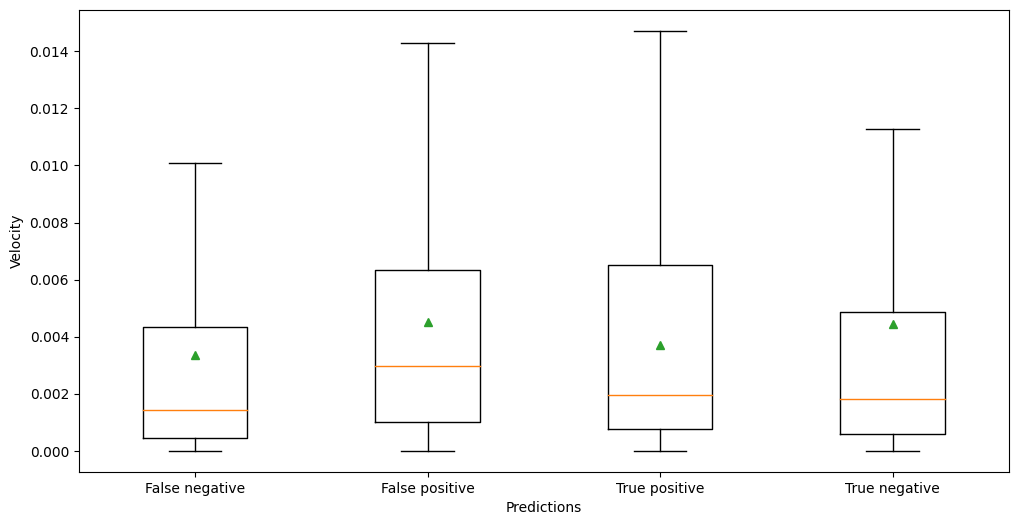

In [42]:
import matplotlib.pyplot as plt

tot_df = [false_negatives, false_positives, true_positives, true_negatives]

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Create boxplot
ax.boxplot([df['velocity'] for df in tot_df], showfliers=False, showmeans=True)

# Set x-axis tick labels
ax.set_xticklabels(['False negative', 'False positive', 'True positive', 'True negative'])

# Set axis labels
ax.set_xlabel('Predictions')
ax.set_ylabel('Velocity')

# Show plot
plt.show()

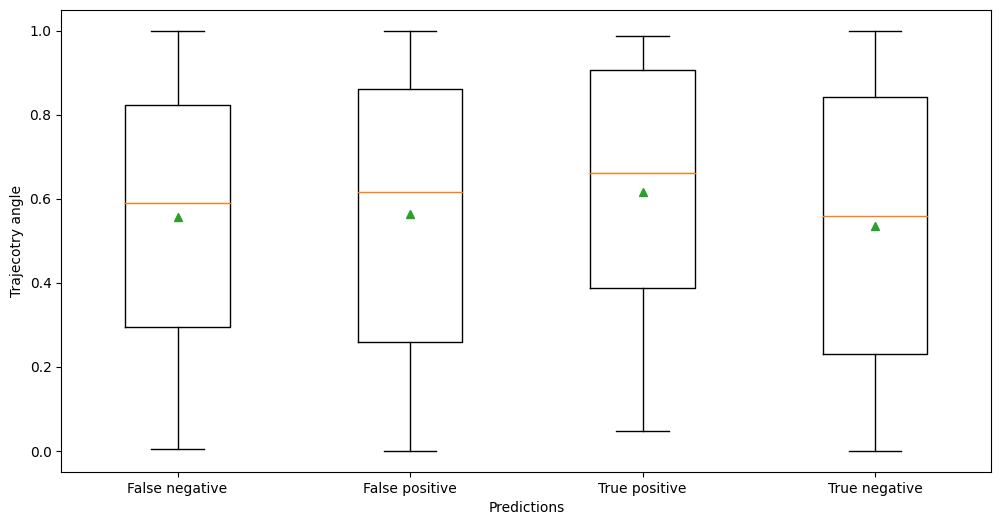

In [43]:
tot_df = [false_negatives, false_positives, true_positives, true_negatives]

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Create boxplot
ax.boxplot([df['angle'] for df in tot_df], showfliers=False, showmeans=True)

# Set x-axis tick labels
ax.set_xticklabels(['False negative', 'False positive', 'True positive', 'True negative'])

# Set axis labels
ax.set_xlabel('Predictions')
ax.set_ylabel('Trajecotry angle')

# Show plot
plt.show()

# Feature importance

angle importance:  0.5353523251137926
velocity importance:  0.46464767488620745


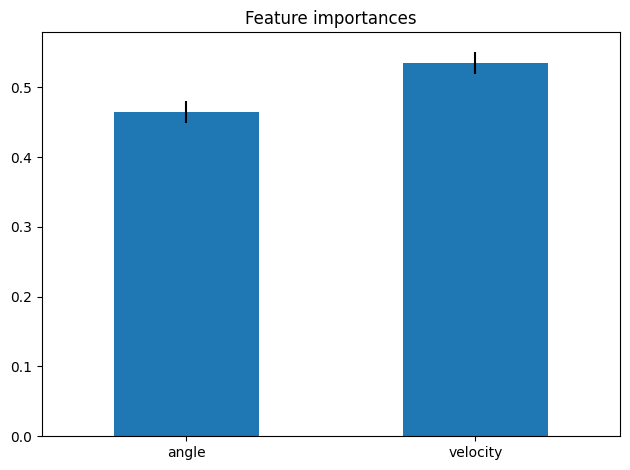

In [33]:
# Get feature importances
importances = rf.feature_importances_

feature_names = df.columns[:-1]
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

for i, feature in enumerate(X_train.columns):
    print(feature, 'importance: ', importances[i-1])

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=360)

fig.tight_layout()

# Partial dependence plots

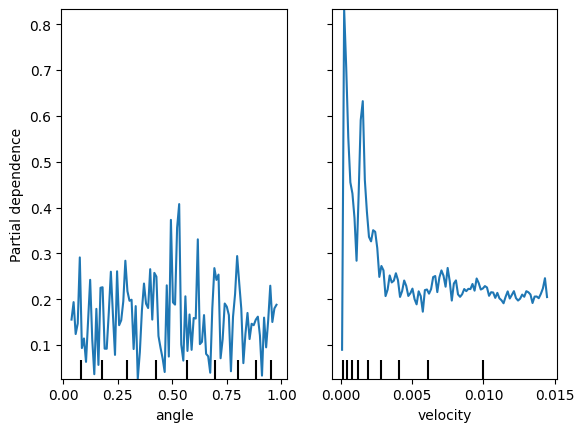

In [48]:
from sklearn.inspection import PartialDependenceDisplay

pdp = PartialDependenceDisplay.from_estimator(rf, X, features=[0, 1])

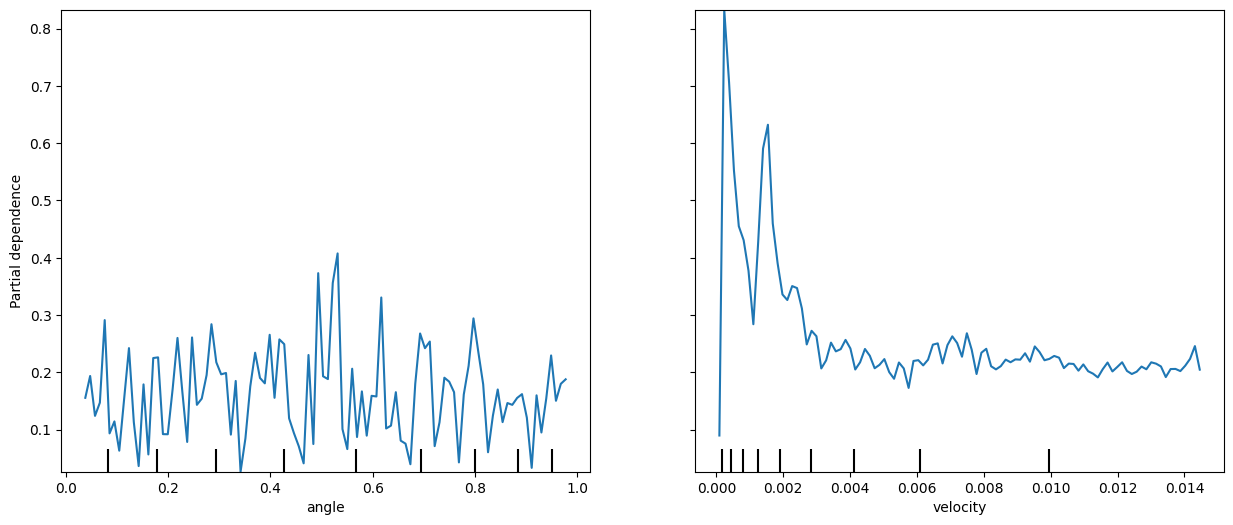

In [58]:
fig, ax = plt.subplots(figsize=(15, 6))
pdp.plot(ax=ax)
plt.show()